# EDA

## Loading data & Package import

### Package import

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

### Data

In [47]:
train_url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(train_url, nrows=10000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Exploration

### Outliers detection

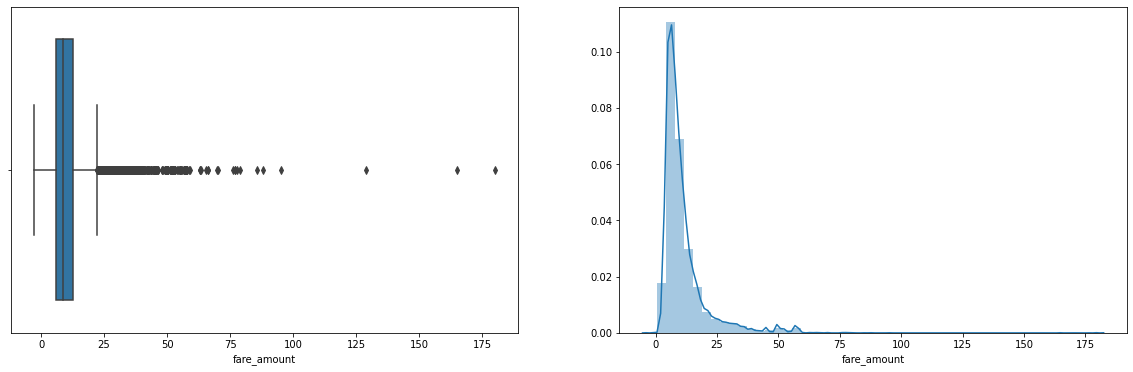

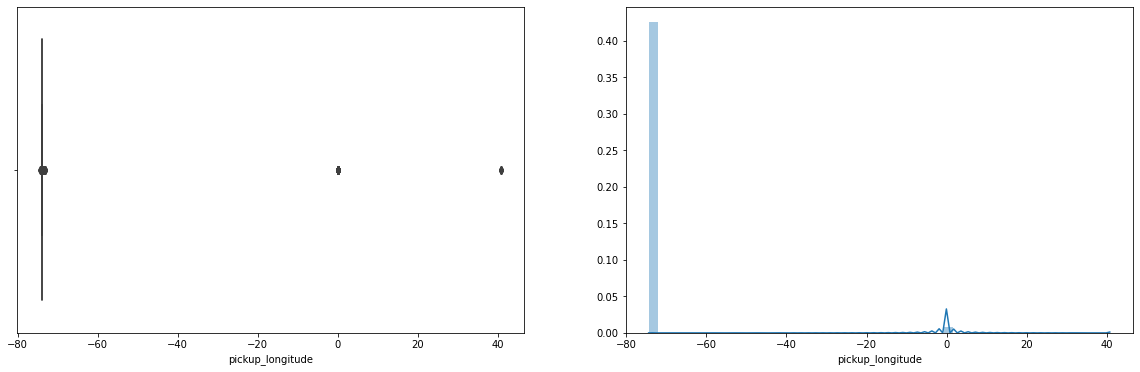

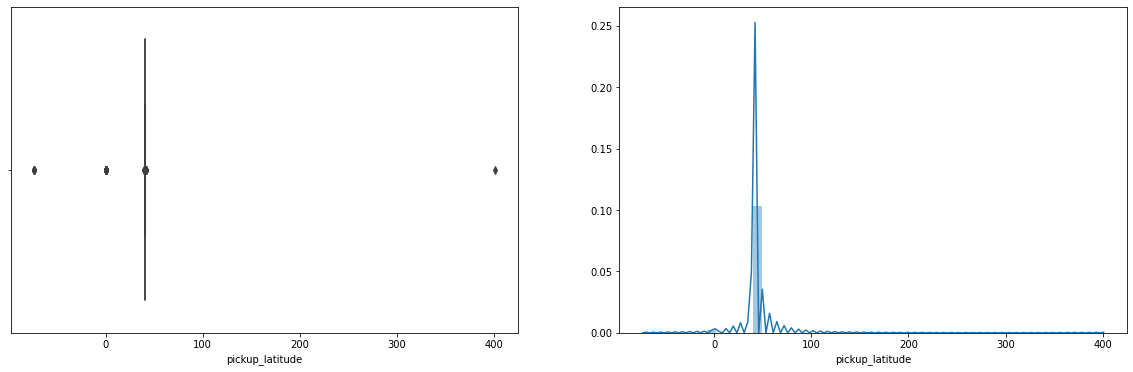

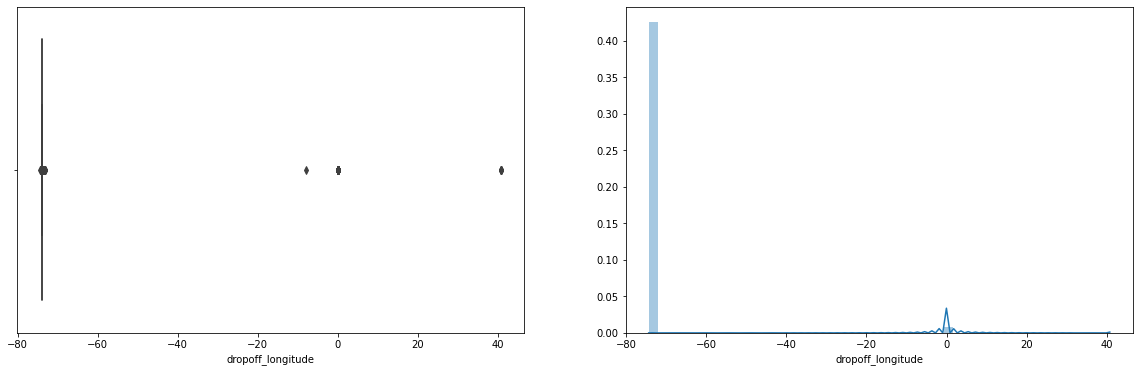

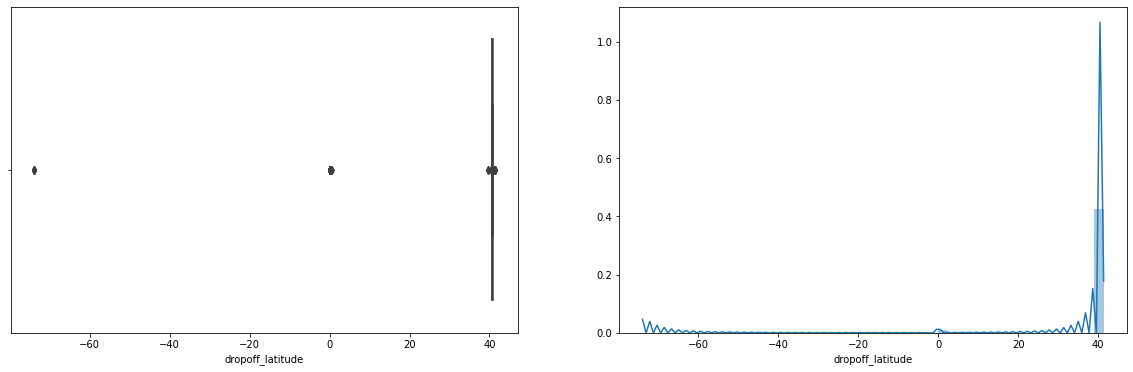

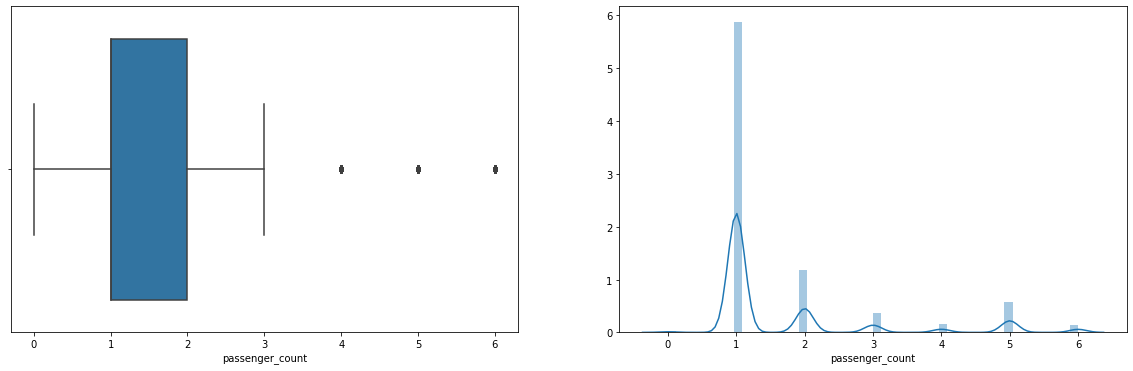

In [48]:
def showme(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    sns.boxplot(df, ax=ax1)
    sns.distplot(df, ax=ax2)

for feat in df.drop(columns=['key', 'pickup_datetime']).columns:
    showme(df[feat])

<h4>Outliers</h4>
<p>Latitude and longitude contain outliers that need to be deleted / dropped. Indeed the outliers represent geographical spots that are hours/days away of NY by car. They are errors.</p> 

<p>Regarding the number of passengers or the fare amount, they seem to be feasible, hence no data cleaning will be performed in this columns.</p>

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
key                  10000 non-null object
fare_amount          10000 non-null float64
pickup_datetime      10000 non-null object
pickup_longitude     10000 non-null float64
pickup_latitude      10000 non-null float64
dropoff_longitude    10000 non-null float64
dropoff_latitude     10000 non-null float64
passenger_count      10000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 625.1+ KB


<h4>Objects</h4>
<p>Index and datetime need to be converted to datetime objects.</p> 

In [50]:
pd.DataFrame(pd.to_datetime(df.key)).head()

,key
0,2009-06-15 17:26:21.000000100
1,2010-01-05 16:52:16.000000200
2,2011-08-18 00:35:00.000000490
3,2012-04-21 04:30:42.000000100
4,2010-03-09 07:51:00.000000135


### Feature exploration

#### Passenger Count Exploration

In [51]:
df.passenger_count.describe()

count    10000.000000
mean         1.644700
std          1.271229
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

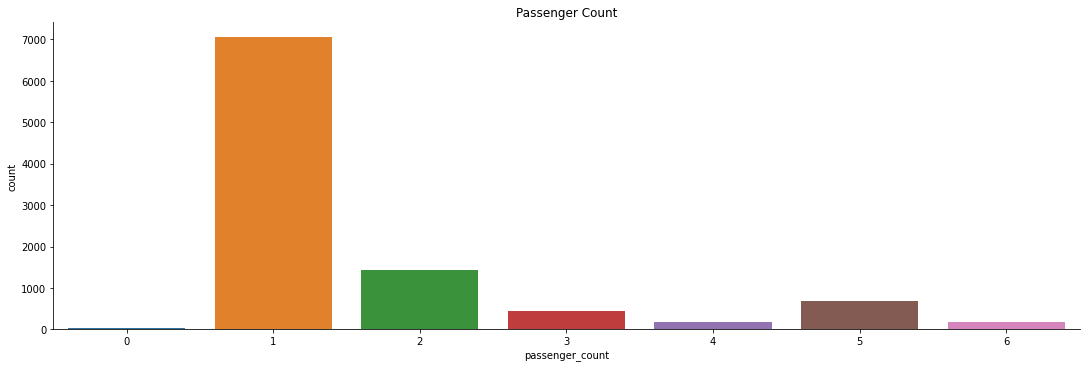

In [52]:
sns.catplot(x="passenger_count", kind="count", data=df, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

#### Pickup Datetime Exploration

In [53]:
def time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df
df = time_features(df)

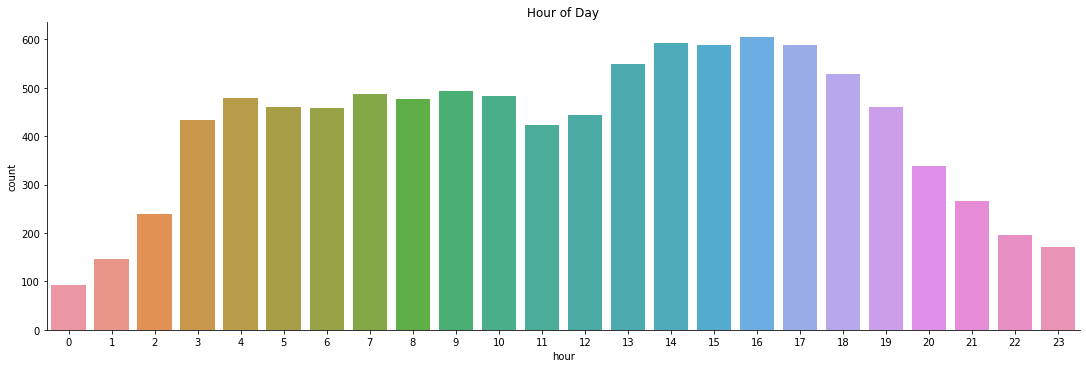

In [54]:
sns.catplot(x="hour", kind="count", data=df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

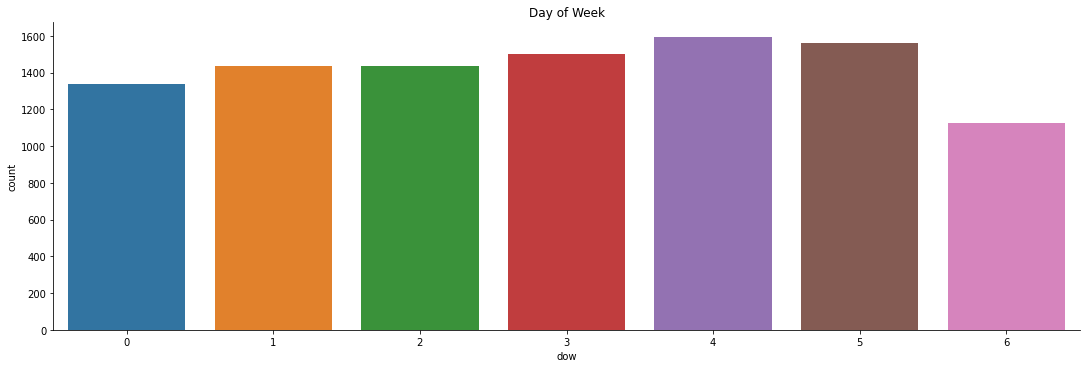

In [55]:
sns.catplot(x="dow", kind="count", data=df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

#### Geospatial data

In [56]:
df_test = pd.read_csv("../lyft/data/test.csv")

for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = df_test[col].min()
    MAX = df_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [57]:
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -75, right = -72 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72 )]

In [58]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [63]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11, tiles='Stamen Toner')

In [67]:
%matplotlib notebook
df["count"]=1
heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude', 'fare_amount']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

## Feature Engineering 

### Globe Distance

In [73]:
def globe_distance(df, start_lat="start_lat", start_lon="start_lon", end_lat="end_lat", end_lon="end_lon"):
    """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees).
        Vectorized version of the haversine distance for pandas df
        Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

df["distance"] = globe_distance(df, start_lat="pickup_latitude", start_lon="pickup_longitude", end_lat="dropoff_latitude", end_lon="pickup_longitude")

In [75]:
df.distance.describe()

count    8535.000000
mean        2.394316
std         3.118895
min         0.000000
25%         0.771248
50%         1.548945
75%         2.910285
max        69.031812
Name: distance, dtype: float64

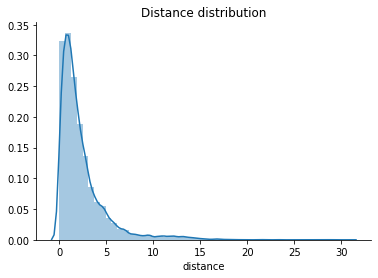

In [76]:
%matplotlib inline
g = sns.distplot(df[df.distance < 50].distance)
sns.despine()
plt.title("Distance distribution")
plt.show()

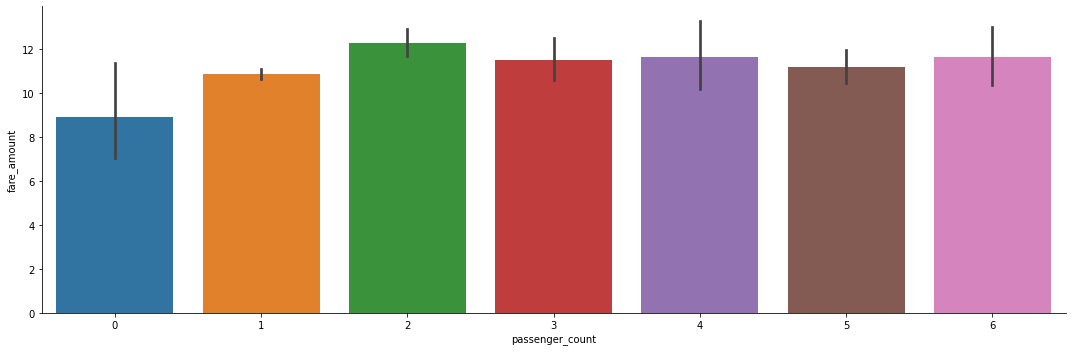

In [79]:
%matplotlib inline
sns.catplot(x="passenger_count", y="fare_amount", data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

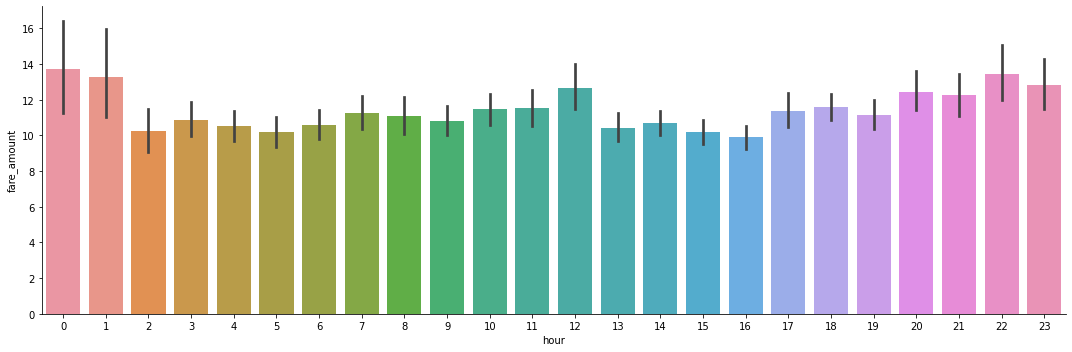

In [81]:
sns.catplot(x="hour", y="fare_amount", data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

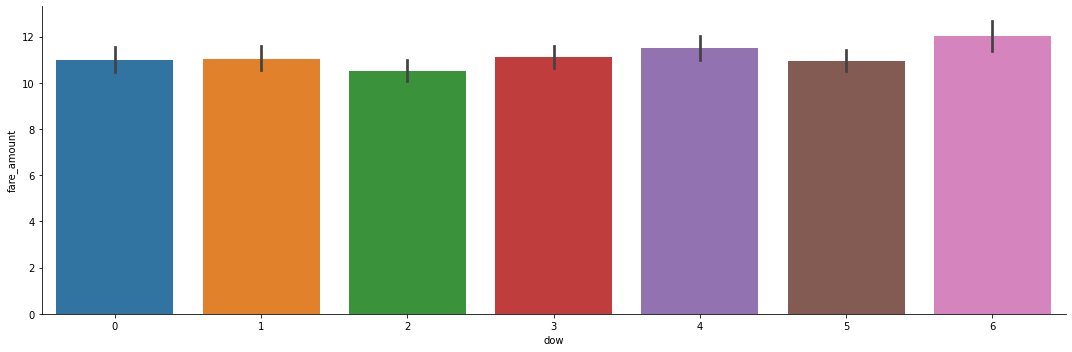

In [82]:
sns.catplot(x="dow", y="fare_amount", data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

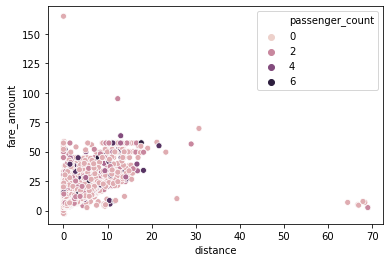

In [84]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df[df.distance < 80])
plt.show()

## Data Cleaning

In [89]:
print("trips with negative fares:", len(df[df.fare_amount <= 0]))
print("trips with too high distance:", len(df[df.distance >= 100]))
print("trips with too many passengers:", len(df[df.passenger_count > 8]))
print("trips with zero passenger:", len(df[df.passenger_count == 0]))

trips with negative fares: 2
trips with too high distance: 0
trips with too many passengers: 0
trips with zero passenger: 31


In [90]:
def clean_data(df, test=False):
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    df = df[df.fare_amount.between(0, 4000)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(40, 42)]
    df = df[df["pickup_longitude"].between(-74.3, -72.9 )]
    df = df[df["dropoff_latitude"].between(40, 42)]
    df = df[df["dropoff_longitude"].between(-74, -72.9)]
    return df

df_cleaned = clean_data(df)
"% data removed", (1 - len(df_cleaned) / len(df)) * 100

('% data removed', 0.023432923257171723)

## Evaluation Metric

In [97]:
def compute_error(y_pred, y_true):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true,y_pred)
    return {'mae': mae, 'mse': mse}

## Naive Baseline Forecast

In [99]:
y_pred = df_cleaned.fare_amount.mean()
df["y_pred"] = df_cleaned.fare_amount.mean()
compute_error(df.y_pred, df.fare_amount)

{'mae': 5.862062224118899, 'mse': 85.01264784189216}

## Modelling

### Train test split

In [103]:
df_train, df_val = train_test_split(df, test_size=10)

In [104]:
df_train = clean_data(df_train)

### Target and features separation

In [106]:
target = "fare_amount"
features = ["distance"]
categorical_features = ["hour", "dow", "passenger_count"]

In [107]:
def transform_features(_df, dummy_features=None):
    encode = True if dummy_features is None else False
    dummy_features = dummy_features if dummy_features is not None else []
    for c in categorical_features:
        dummies = pd.get_dummies(_df[c], prefix=c)
        _df = pd.concat([_df, dummies], axis=1)
        if encode:
            dummy_features = dummy_features + (list(dummies.columns.values))
    for dummy_feature in [f for f in dummy_features if f not in _df.columns]:
        _df[dummy_feature] = 0 
    _df = _df[dummy_features + features]
    return _df, dummy_features

In [110]:
clf = LassoCV(cv=5, n_alphas=5)
X_train, dummy_features = transform_features(df_train)
y_train = df_train.fare_amount
clf.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=5, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

### Model evaluation

In [113]:
X_val, _ = transform_features(df_val, dummy_features=dummy_features)
df_val["y_pred"] = clf.predict(X_val)
compute_rmse(df_val.y_pred, df_val.fare_amount)

/Users/edgarminault/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


5.51581611859572

### Prediction

In [116]:
df_test["distance"] = globe_distance(df_test, 
                                   start_lat="pickup_latitude", start_lon="pickup_longitude",
                                   end_lat="dropoff_latitude", end_lon="pickup_longitude"
                                  )
df_test = time_features(df_test)
X_test, _ = transform_features(df_test, dummy_features=dummy_features) 
df_test["y_pred"] = clf.predict(X_test)

In [118]:
df_test.reset_index(drop=True)[["key", "y_pred"]].rename(columns={"y_pred": "fare_amount"}).to_csv("../output_csvs/lasso_v0_predictions.csv", index=False)